# **Bài toán**

**Vấn đề**: Việc đạt được lợi nhuận tối ưu luôn là mục tiêu hàng đầu của các nhà sản xuất phim và nhà đầu tư. Họ không chỉ muốn tạo ra những tác phẩm điện ảnh chất lượng, mà còn mong muốn dự đoán được khả năng sinh lời của phim dựa trên các yếu tố như: ngân sách sản xuất, ngôn ngữ sử dụng, thời điểm ra mắt, thể loại phim, và nhiều yếu tố khác. Đây là một thách thức lớn, nhưng cũng là cơ hội để tối ưu hóa quyết định đầu tư và tạo ra lợi nhuận tối đa.

**Mục tiêu**: Dự án này nhằm mục tiêu xây dựng một mô hình dự đoán doanh thu phim dựa trên các thông tin đầu vào như ngân sách sản xuất, ngôn ngữ, thời gian chiếu, thể loại phim, v.v., sử dụng phương pháp Support Vector Regression (SVR) và Phân tích thành phần chính (PCA). Mục tiêu cụ thể bao gồm:

1. Thu thập dữ liệu: Sử dụng TMDB API để lấy thông tin về phim, bao gồm các thuộc tính của một bộ phim: buget, cast, release date, ...

2. Phân tích và tiền xử lý dữ liệu: Chúng tôi sẽ tiến hành phân tích kỹ lưỡng dữ liệu thu thập từ TMDB API, thực hiện các bước tiền xử lý cần thiết để dữ liệu có thể được sử dụng hiệu quả trong việc xây dựng mô hình.

3. Trực quan hóa dữ liệu

4. Tạo một baseline model (sử dụng hồi quy tuyến tính)

5. Xây dựng mô hình dự đoán: Chúng tôi sẽ sử dụng phương pháp SVR để xây dựng mô hình dự đoán doanh thu phim. Mô hình này sẽ được huấn luyện và tinh chỉnh để đạt được hiệu suất tốt nhất.

6. Giảm chiều dữ liệu: Sử dụng PCA để giảm số lượng biến đầu vào, giữ lại những biến quan trọng nhất giúp tăng hiệu suất của mô hình và giảm thời gian huấn luyện. So sánh mô hình sau khi giảm chiều dữ liệu với mô hình trước đó.

7. Đánh giá và kiểm tra mô hình: Chúng tôi sẽ sử dụng các phương pháp đánh giá mô hình như cross-validation để đảm bảo mô hình hoạt động tốt và có thể dự đoán chính xác doanh thu phim.

Chúng tôi hy vọng rằng với mục tiêu này, dự án sẽ mang lại giá trị thực tế và đóng góp vào sự phát triển của ngành công nghiệp điện ảnh.


## **1. Thu thập dữ liệu**

In [ ]:
import requests
import pandas as pd
import json

def get_movie_ids(api_key):
  LANGUAGE = "en-US"
  PAGES = 500

  IDs = []

  get_ids_url = "https://api.themoviedb.org/3/movie/popular?"

  header = {
      "language": LANGUAGE,
      "api_key": api_key
  }

  for page in range(1, PAGES + 1):
      header["page"] = page
      response = requests.get(get_ids_url, params = header)
      data = json.loads(response.text)
      IDs += [item["id"] for item in data['results'] if "id" in item]

  return IDs

def get_movie_details(api_key, movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    params = {
        "api_key": api_key,
        "language": "en-US"
    }
    response = requests.get(url, params=params)
    return response.json()

api_key = "072a9e6861bd4696c22bd14c061911c7"
movie_ids = get_movie_ids(api_key)

all_movie_details = []
for movie_id in movie_ids:
    print(f"Fetching details for movie ID: {movie_id}")
    details = get_movie_details(api_key, movie_id)
    all_movie_details.append(details)

df = pd.DataFrame(all_movie_details)
df.to_csv('raw_data.csv', index=False)


## **2. Làm sạch và chuẩn hóa dữ liệu**

### 1.Làm sạch dữ liệu

In [1]:
#Import thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('./Data/raw_data.csv',  lineterminator='\n')

- Xử lý tổng quan dữ liệu

In [4]:
#Loại bỏ các cột trùng nhau
df.duplicated().sum()
df.drop_duplicates(inplace=True)

#Xóa các cột không liên quan và không thể dùng để huấn luyện như các cột chứa liên kết, id ..., xóa luôn cột status, adult vì mọi giá trị đều là released, False ko có tác dụng trong huấn luyện
df.drop(columns=['adult', 'backdrop_path', 'id', 'imdb_id', 'poster_path', 'video', 'production_companies', 'production_countries', 'spoken_languages', 'belongs_to_collection', 'status', 'original_title'], axis=1, inplace=True)

#Loại bỏ những cột có revenue = 0
(df['revenue'] == 0).sum()
df = df[df['revenue'] != 0]
df = df[df['budget'] != 0]

#Loại bỏ những cột ko có các thuộc tính text dùng đến
# df.dropna(subset=['overview', 'title', 'tagline'], inplace=True)
df['overview'] = df['overview'].fillna("")
df['title'] = df['title'].fillna("")
df['tagline'] = df['tagline'].fillna("")


- Xử lý cột homepage vì nhận thấy rằng những film có homepage thì sẽ có một chút nhỉnh hơn về revenue (nhận biết qua đồ thị dưới đây)

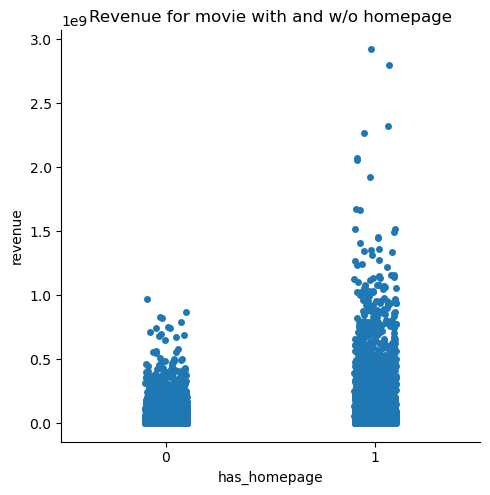

In [5]:
#Tạo ra một cột mới xác định một film có homepage hay không
df['has_homepage'] = 0
df.loc[df['homepage'].isnull() == False, 'has_homepage'] = 1 #1 nghĩa là có homepage
#since has_homepage is categorical value we will be using seaborn catplot.
sns.catplot(x='has_homepage', y='revenue', data=df);
plt.title('Revenue for movie with and w/o homepage');
#Xóa cột homepage
df.drop(columns='homepage', axis=1, inplace=True)

- Xử lý các cột chứa văn bản như title, overview, tagline...
- Các cột chứa thông tin văn bản như tiêu đề, tóm tắt có thể đóng vai trò quan trọng trong việc tác động đến doanh thu của phim, vì chúng có thể là yếu tố quyết định cho sự chú ý và hấp dẫn từ phía khán giả.

In [6]:
#import thư viện cần thiết để xử lý văn bản
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hungt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Chuyển các cột chứa văn bản thành các mảng một chiều
def convert_to_1D_array(name):
    columns = [name]
    array = df[columns].to_numpy()
    array1D = array.flatten()
    return array1D
#hàm xóa stopword của một câu
def remove_english_stopwords_func(text):
    '''
    Removes Stop Words (also capitalized) from a string, if present

    Args:
        text (str): String to which the function is to be applied, string

    Returns:
        Clean string without Stop Words
    '''
    # check in lowercase
    t = [token for token in text if token.lower() not in stopwords.words("english")]
    text = ' '.join(t)
    return text
#Xóa stopword trong các câu
def remove_stopword(arr):
    arrClean = []
    for sentence in arr:
        #Chuyển câu thành mảng các word
        tokens_text_for_stop_words = word_tokenize(sentence)
        #Trả về các câu đã xóa stopword
        arrClean.append(remove_english_stopwords_func(tokens_text_for_stop_words))
    return arrClean
# Xóa hết những dấu không cần thiết trong câu như dấu . , ...
def remove_symbol(arrClean):
    arrClean2 = []
    for sentence in arrClean:
        cleanString = re.sub('\W+'," ", sentence)
        arrClean2.append(cleanString)
    return arrClean2

#kết hợp những hàm trên
def processDFtext(name_of_column):
    arr = convert_to_1D_array(name_of_column)
    arrClean = remove_stopword(arr)
    arrClean2 = remove_symbol(arrClean)
    return arrClean2

In [10]:
#Huấn luyện mô hình Doc2Vec để chuyển văn bản thành các vector đại diện
from gensim.models.doc2vec import Doc2Vec,TaggedDocument

def get_vector_from_doc2Vec(arrClean2, vector_size):
    # define a list of documents.
    data = arrClean2

    # preproces the documents, and create TaggedDocuments
    tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(data)]

    # train the Doc2vec model
    model = Doc2Vec(vector_size=vector_size, min_count=2, epochs=50)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    # get the document vectors
    document_vectors = [model.infer_vector(word_tokenize(doc.lower())) for doc in data]
    arrVector = []
    #  print the document vectors
    for i, doc in enumerate(data):
        arrVector.append(document_vectors[i])
        # print("Document", i+1, ":", doc)
        # print("Vector:", document_vectors[i])
        # print()
    return arrVector
# Chuẩn hóa cột vector sử dụng Cosine Similarity
from numpy.linalg import norm
def normalizationTextFromVec(arrVector):
    vectorNormalization = []
    vectorNormalization.append(1) # lấy vector đầu làm vector tiêu chuẩn
    for i in range(1, len(arrVector)):
        vectorNormalization.append(np.dot(arrVector[i], arrVector[0])/(norm(arrVector[i]) * norm(arrVector[0])))
    return vectorNormalization

In [11]:
#ket hợp tất cả các hàm ở trên để đưa ra giá trị chuẩn hóa của cột chứa text
def dftext_to_dfnormalization(nameOfColumn, vectorSize):
    arrCleaned = processDFtext(nameOfColumn)
    arrVector = get_vector_from_doc2Vec(arrCleaned, vectorSize)
    vectorNormalization = normalizationTextFromVec(arrVector)
    return vectorNormalization

In [12]:
overviewNormalization = dftext_to_dfnormalization('overview', 100)
titleNormalization = dftext_to_dfnormalization('title', 20)
taglineNormalization = dftext_to_dfnormalization('tagline', 20)

In [13]:
df['Overview Normalization'] = overviewNormalization
df['Title Normalization'] = titleNormalization
df['Tagline Normalization'] = taglineNormalization
df.drop(columns = ['overview', 'title', 'tagline'], axis=1, inplace=True)

- Xử lý cột thời gian phát hành
- Cột thời gian phát hành đóng vai trò quan trọng trong việc ảnh hưởng đến doanh thu của bộ phim, vì thời điểm này thường xác định mức độ tiếp cận và sự quan tâm từ phía khán giả.

In [14]:
from datetime import datetime
df['release_date'] = pd.to_datetime(df['release_date'])
fixed_day = "2024-05-01" # ngày crawl dữ liệu
#Tính số ngày phát hành đến thời điểm crawl
fixed_day = datetime.strptime(fixed_day, '%Y-%m-%d')
df['Number day released'] = (fixed_day - df['release_date']).dt.days
df.drop(columns=['release_date'], axis=1, inplace=True)

- Xử lý cột genres: Thể loại phim là một yếu tố quyết định có ảnh hưởng sâu rộng đến doanh thu của một bộ phim. Các thể loại khác nhau không chỉ thu hút đối tượng khán giả riêng biệt mà còn tạo ra các kỳ vọng và mong đợi khác nhau từ phía khán giả, từ đó ảnh hưởng đến việc quyết định xem phim và mức độ hài lòng của họ sau khi xem

In [15]:
import json
import pandas as pd

# Hàm trích xuất tên thể loại từ chuỗi JSON
def extract_genre_names(genres_str):
        genres_str = genres_str.replace("'", '"')
        genres_list = json.loads(genres_str)
        genre_names = [genre['name'] for genre in genres_list]
        return genre_names
df['genre_names'] = df['genres'].apply(lambda x: extract_genre_names(x))

In [16]:
#Tạo ra các cột thể loại và gán giá trị 1 hoặc 0 tương ứng
genres = np.unique(",".join(df['genre_names'].astype(str).apply(lambda x: x.replace(', ', ','))).replace('[', '').replace(']', '').replace("'", '').split(','))

for genre in genres:
    df[genre] = df['genre_names'].apply(lambda x: 1 if genre in x else 0)
df.drop(columns=['genres', 'genre_names'], axis=1, inplace=True)


- Xử lý cột original_language

In [17]:
df['original_language'].value_counts()

original_language
en    4612
fr      91
ja      69
es      48
ko      43
zh      41
cn      31
it      26
hi      25
de      17
da      15
ru      14
no       9
sv       6
te       5
fi       4
pl       4
pt       4
th       3
id       3
uk       2
tr       2
cs       2
el       2
hu       1
kn       1
ml       1
gl       1
nl       1
ar       1
Name: count, dtype: int64

In [18]:
#Do sự chênh lệch về số lượng original language nên những original languege có số lần xuất hiện < 20 sẽ chuyển thành other
counts = df['original_language'].value_counts()

# Gán 'other' cho các giá trị có số lượng xuất hiện ít hơn 20
df.loc[df['original_language'].isin(counts[counts < 20].index), 'original_language'] = 'other'

- Xử lý cột origin_country

In [19]:
df['origin_country'].value_counts()

origin_country
['US']                      3659
['US', 'GB']                 176
['GB']                       142
['GB', 'US']                 139
['CA', 'US']                 110
                            ... 
['ZA', 'US', 'IT', 'GB']       1
['PL', 'GB']                   1
['DE', 'IT']                   1
['EC', 'IN', 'AE', 'US']       1
['LB']                         1
Name: count, Length: 224, dtype: int64

In [20]:
#Do sự chênh lệch về số lượng origin country nên những origin country có số lần xuất hiện < 30 sẽ chuyển thành other
countsCT = df['origin_country'].value_counts()

# Gán 'other' cho các giá trị có số lượng xuất hiện ít hơn 30
df.loc[df['origin_country'].isin(countsCT[countsCT < 30].index), 'origin_country'] = 'other'

In [21]:
df['origin_country'] = df['origin_country'].astype(str).apply(lambda x: x.replace(', ', ',').replace('[', '').replace(']', '').replace("'", ''))

In [22]:
# Encode cột origin_country
unique_languages = df['origin_country'].unique()
# Tạo từ điển ánh xạ từ ngôn ngữ sang số
language_mapping = {language: idx for idx, language in enumerate(unique_languages)}
df['origin_country_encoded'] = df['origin_country'].map(language_mapping)

In [23]:
# Encode cột original_language
unique_languages = df['original_language'].unique()
# Tạo từ điển ánh xạ từ ngôn ngữ sang số
language_mapping = {language: idx for idx, language in enumerate(unique_languages)}
df['original_language_encoded'] = df['original_language'].map(language_mapping)

- Chú ý: Những thứ cần làm với BTL \
Based line, sample dữ liệu sao cho nó liên quan , tối ưu mô hình, interpretion(bài toán giải quyết được cái gì, mô hình có giải quyết được ko, tại sao đc/ko đc)


## **3. Trực quan hóa dữ liệu**


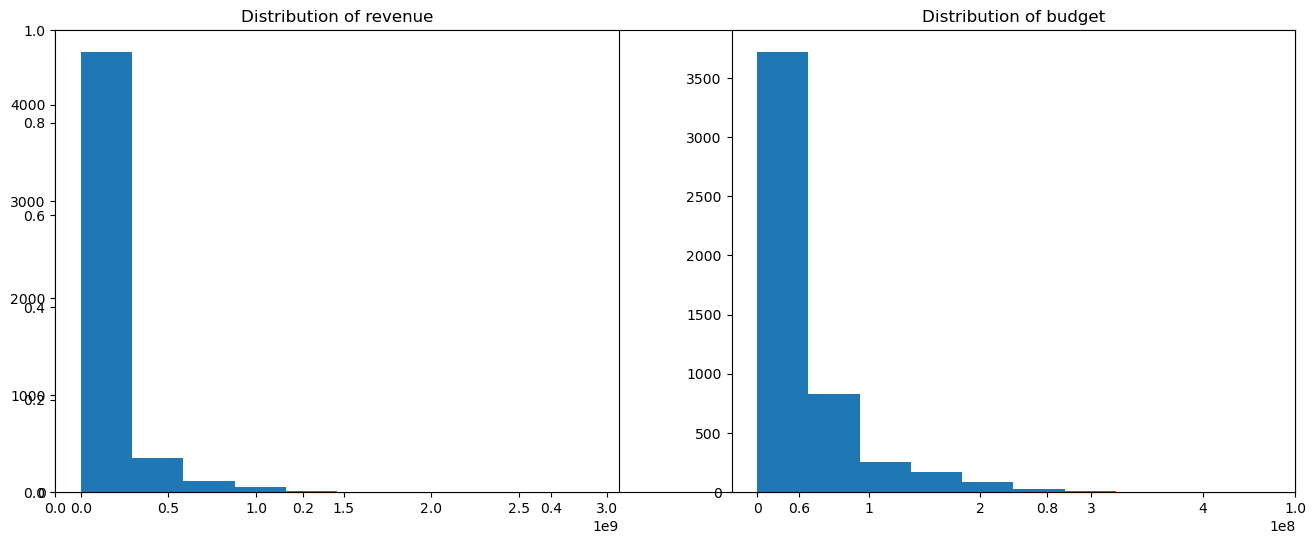

In [24]:
# Biểu đồ phân phối của doanh thu và ngân sách
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(df['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(df['budget']);
plt.title('Distribution of budget');

In [25]:
df['log_budget'] = np.log1p(df['budget']) 
df['log_revenue'] = np.log1p(df['revenue'])

Text(0.5, 1.0, 'Distribution of log budget')

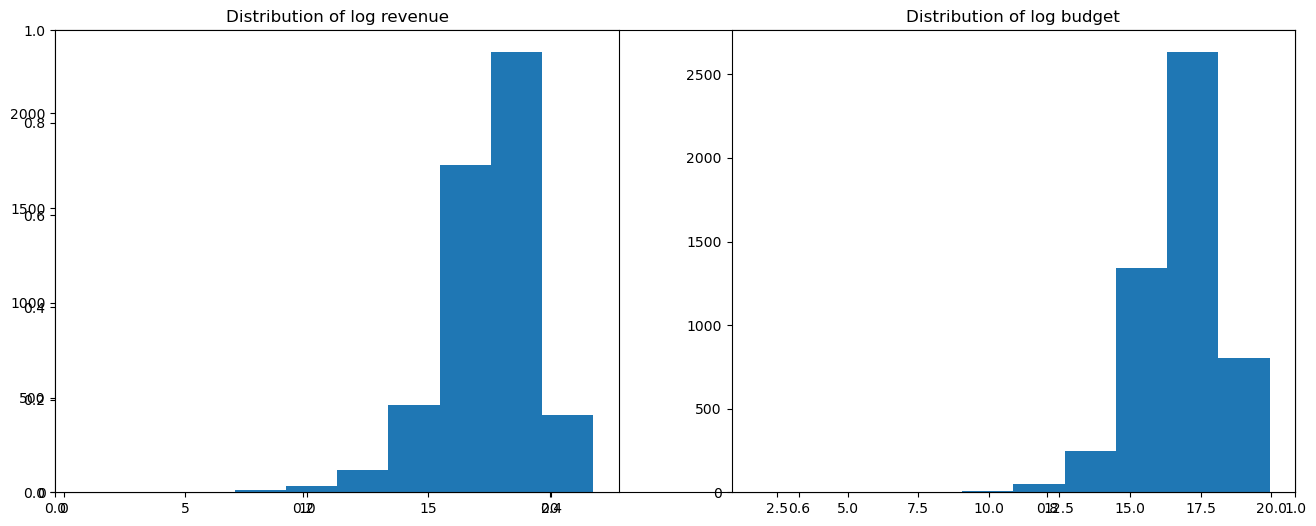

In [26]:
# Biểu đồ phân phối của log revenue và log budget
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(df['log_revenue'])
plt.title('Distribution of log revenue')
plt.subplot(1, 2, 2)
plt.hist(df['log_budget'])
plt.title('Distribution of log budget')

Text(0.5, 1.0, 'Log Revenue vs Overview fig(2)')

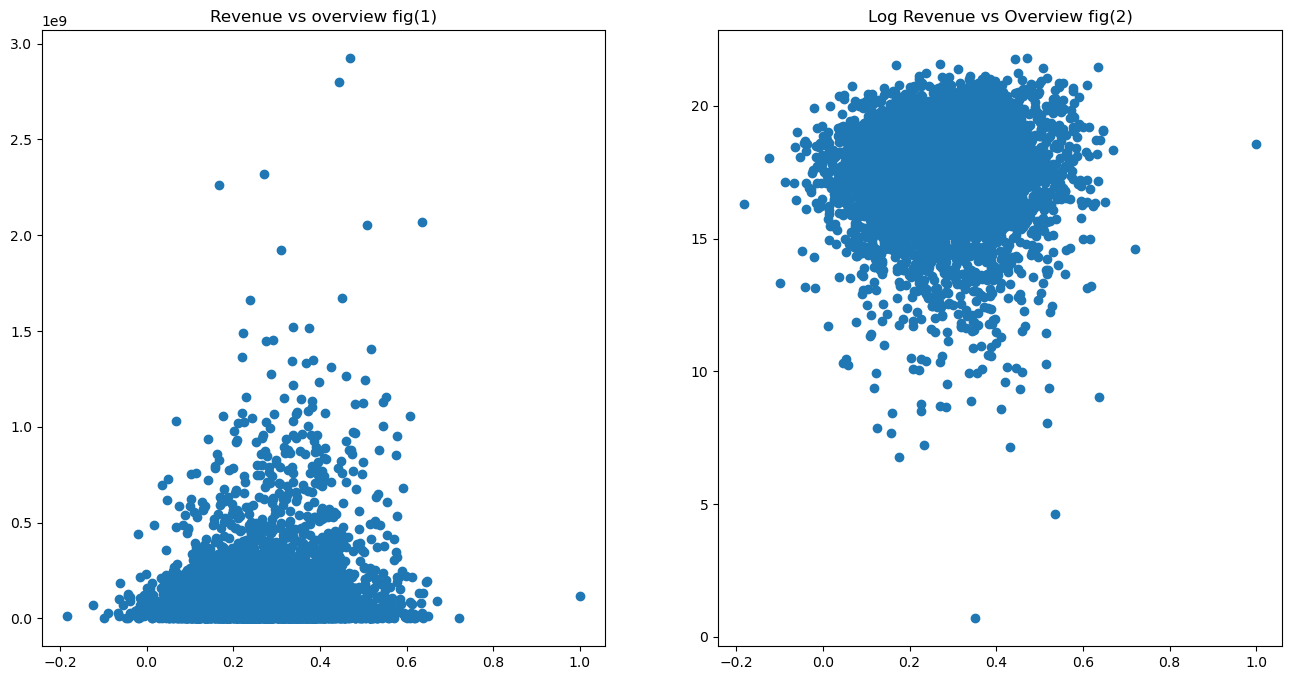

In [27]:
#Biều đồ scatter giữa overview normalization với revenue và log revenue
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(df['Overview Normalization'], df['revenue'])
plt.title('Revenue vs overview fig(1)')
plt.subplot(1, 2, 2)
plt.scatter(df['Overview Normalization'], df['log_revenue'])
plt.title('Log Revenue vs Overview fig(2)')

Text(0.5, 1.0, 'Mean log revenue per language fig_2')

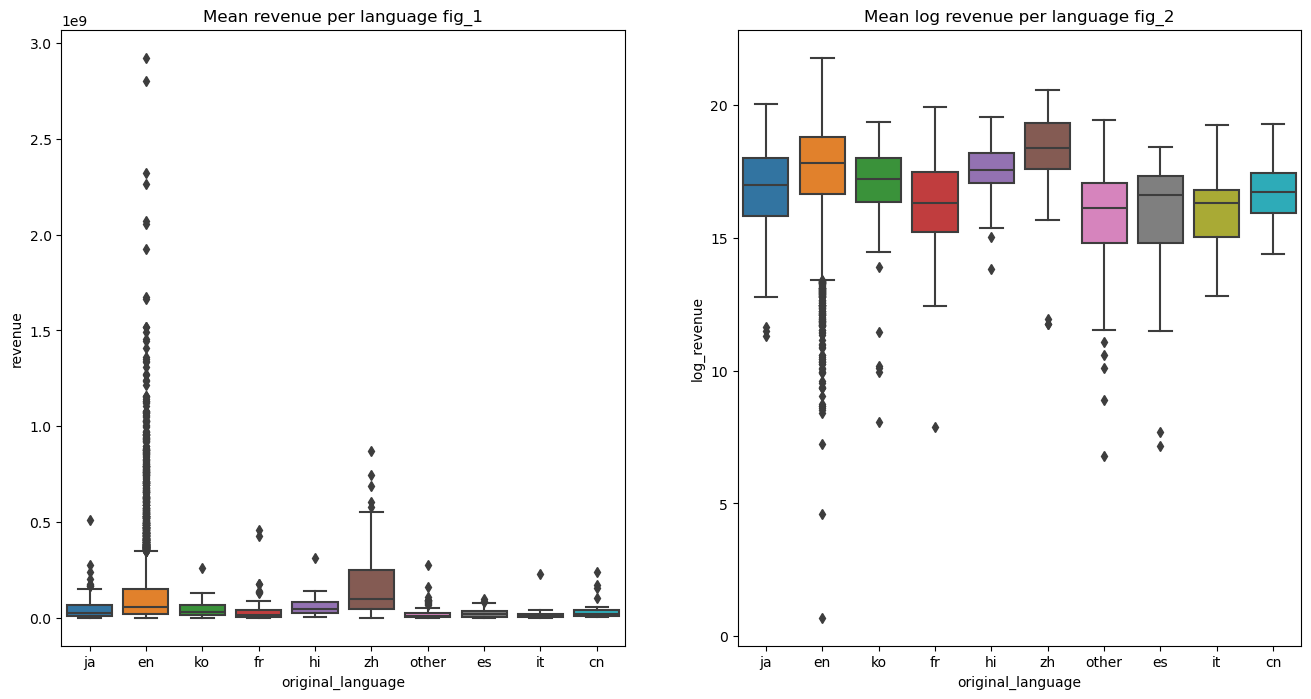

In [28]:
# Biểu đồ mối quan hệ giữa Language và Revenue
# Sử dụng boxplot vì biểu đồ này thích hợp cho việc xác định các giá trị ngoại lệ
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=df.loc[df['original_language'].isin(df['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language fig_1')
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=df.loc[df['original_language'].isin(df['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language fig_2')

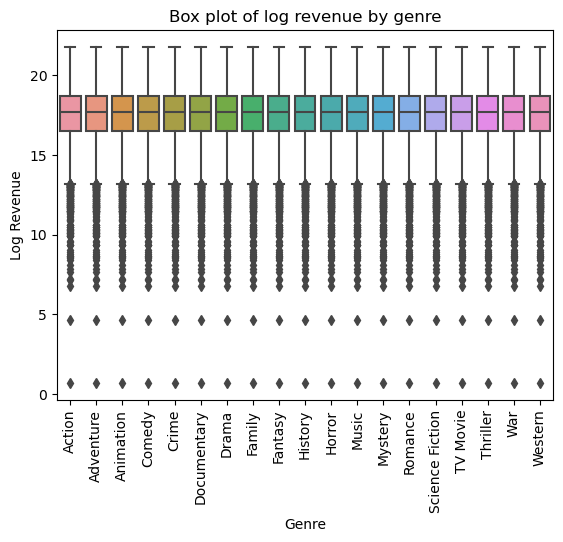

In [29]:
#Box plot giữa các genre và log revenue

# Tạo một DataFrame mới với các cột phù hợp cho việc vẽ box plot
melted_df = pd.melt(df, id_vars=['log_revenue'], value_vars=genres, var_name='Genre')

# Vẽ box plot
sns.boxplot(x='Genre', y='log_revenue', data=melted_df)
plt.title('Box plot of log revenue by genre')
plt.xlabel('Genre')
plt.ylabel('Log Revenue')
plt.xticks(rotation=90)  # Xoay nhãn trục x để dễ đọc
plt.show()

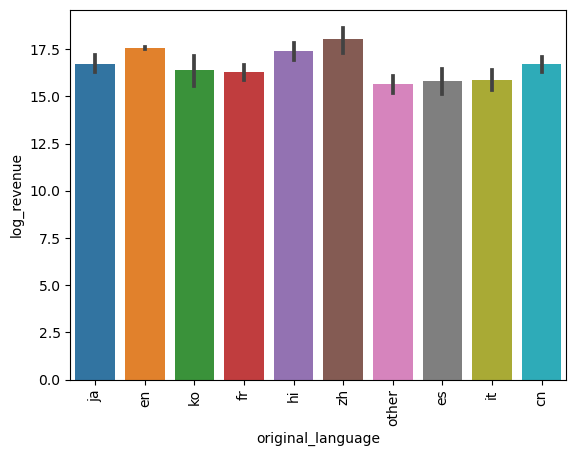

In [30]:
#Biểu đồ thể hiện mối giá trung bình của từng loại phim có ngôn ngữ khác nhau
sns.barplot(x=df['original_language'], y=df['log_revenue'])
plt.xticks(rotation='vertical')
plt.show()
df.drop(columns=['original_language'], axis=1, inplace=True)

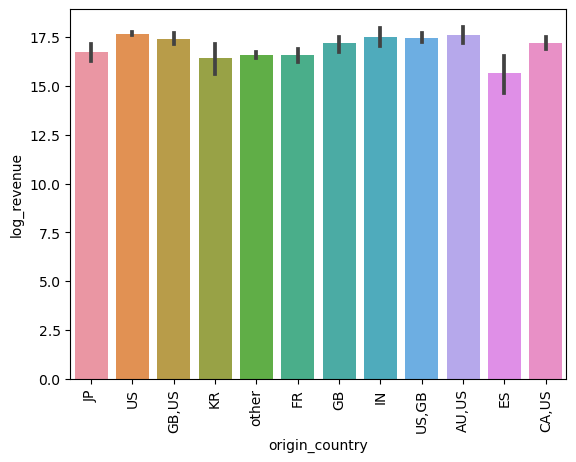

In [31]:
#Biểu đồ thể hiện mối giá trung bình của từng loại phim có quốc khác nhau
sns.barplot(x=df['origin_country'], y=df['log_revenue'])
plt.xticks(rotation='vertical')
plt.show()
df.drop(columns=['origin_country'], axis=1, inplace=True)

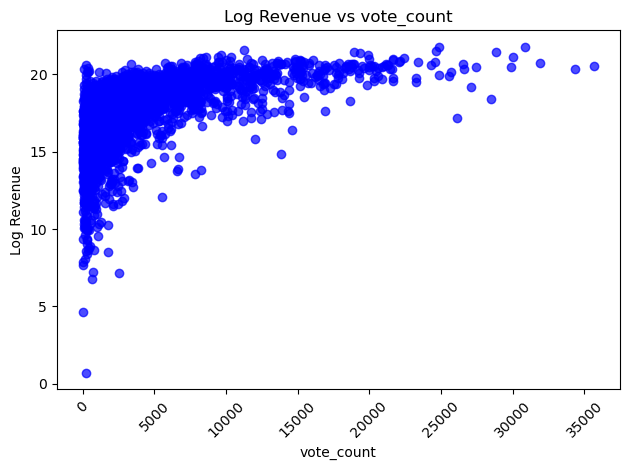

In [32]:
import matplotlib.pyplot as plt

# Sắp xếp DataFrame theo cột 'vote_count'
df = df.sort_values(by='vote_count')

# Vẽ biểu đồ phân tán giữa vote_count và log_revenue
plt.scatter(df['vote_count'], df['log_revenue'], color='b', alpha=0.7)

plt.xlabel('vote_count')
plt.ylabel('Log Revenue')

plt.title('Log Revenue vs vote_count')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

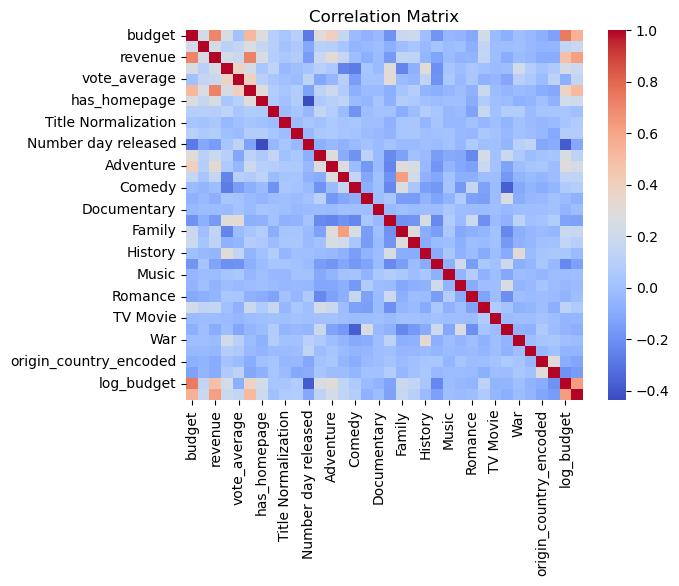

In [33]:
#Biểu đồ thể hiện sự tương quan giữa các đặc trưng của phim
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix , cmap='coolwarm' ,fmt=".2f")
# sns.heatmap(corr_matrix, annot=True , cmap='coolwarm' ,fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [34]:
# Tạo một cột xác định mức độ doanh thu theo các mức cao, thấp, vừa
def mapping_log_revenue(x):
    if x < df['log_revenue'].mean() - df['log_revenue'].var()/2:
        return 'low'
    elif x > df['log_revenue'].mean() + df['log_revenue'].var()/2:
        return 'high'
    else:
        return 'normal'
df['log_revenue_level'] = df['log_revenue'].apply(mapping_log_revenue)


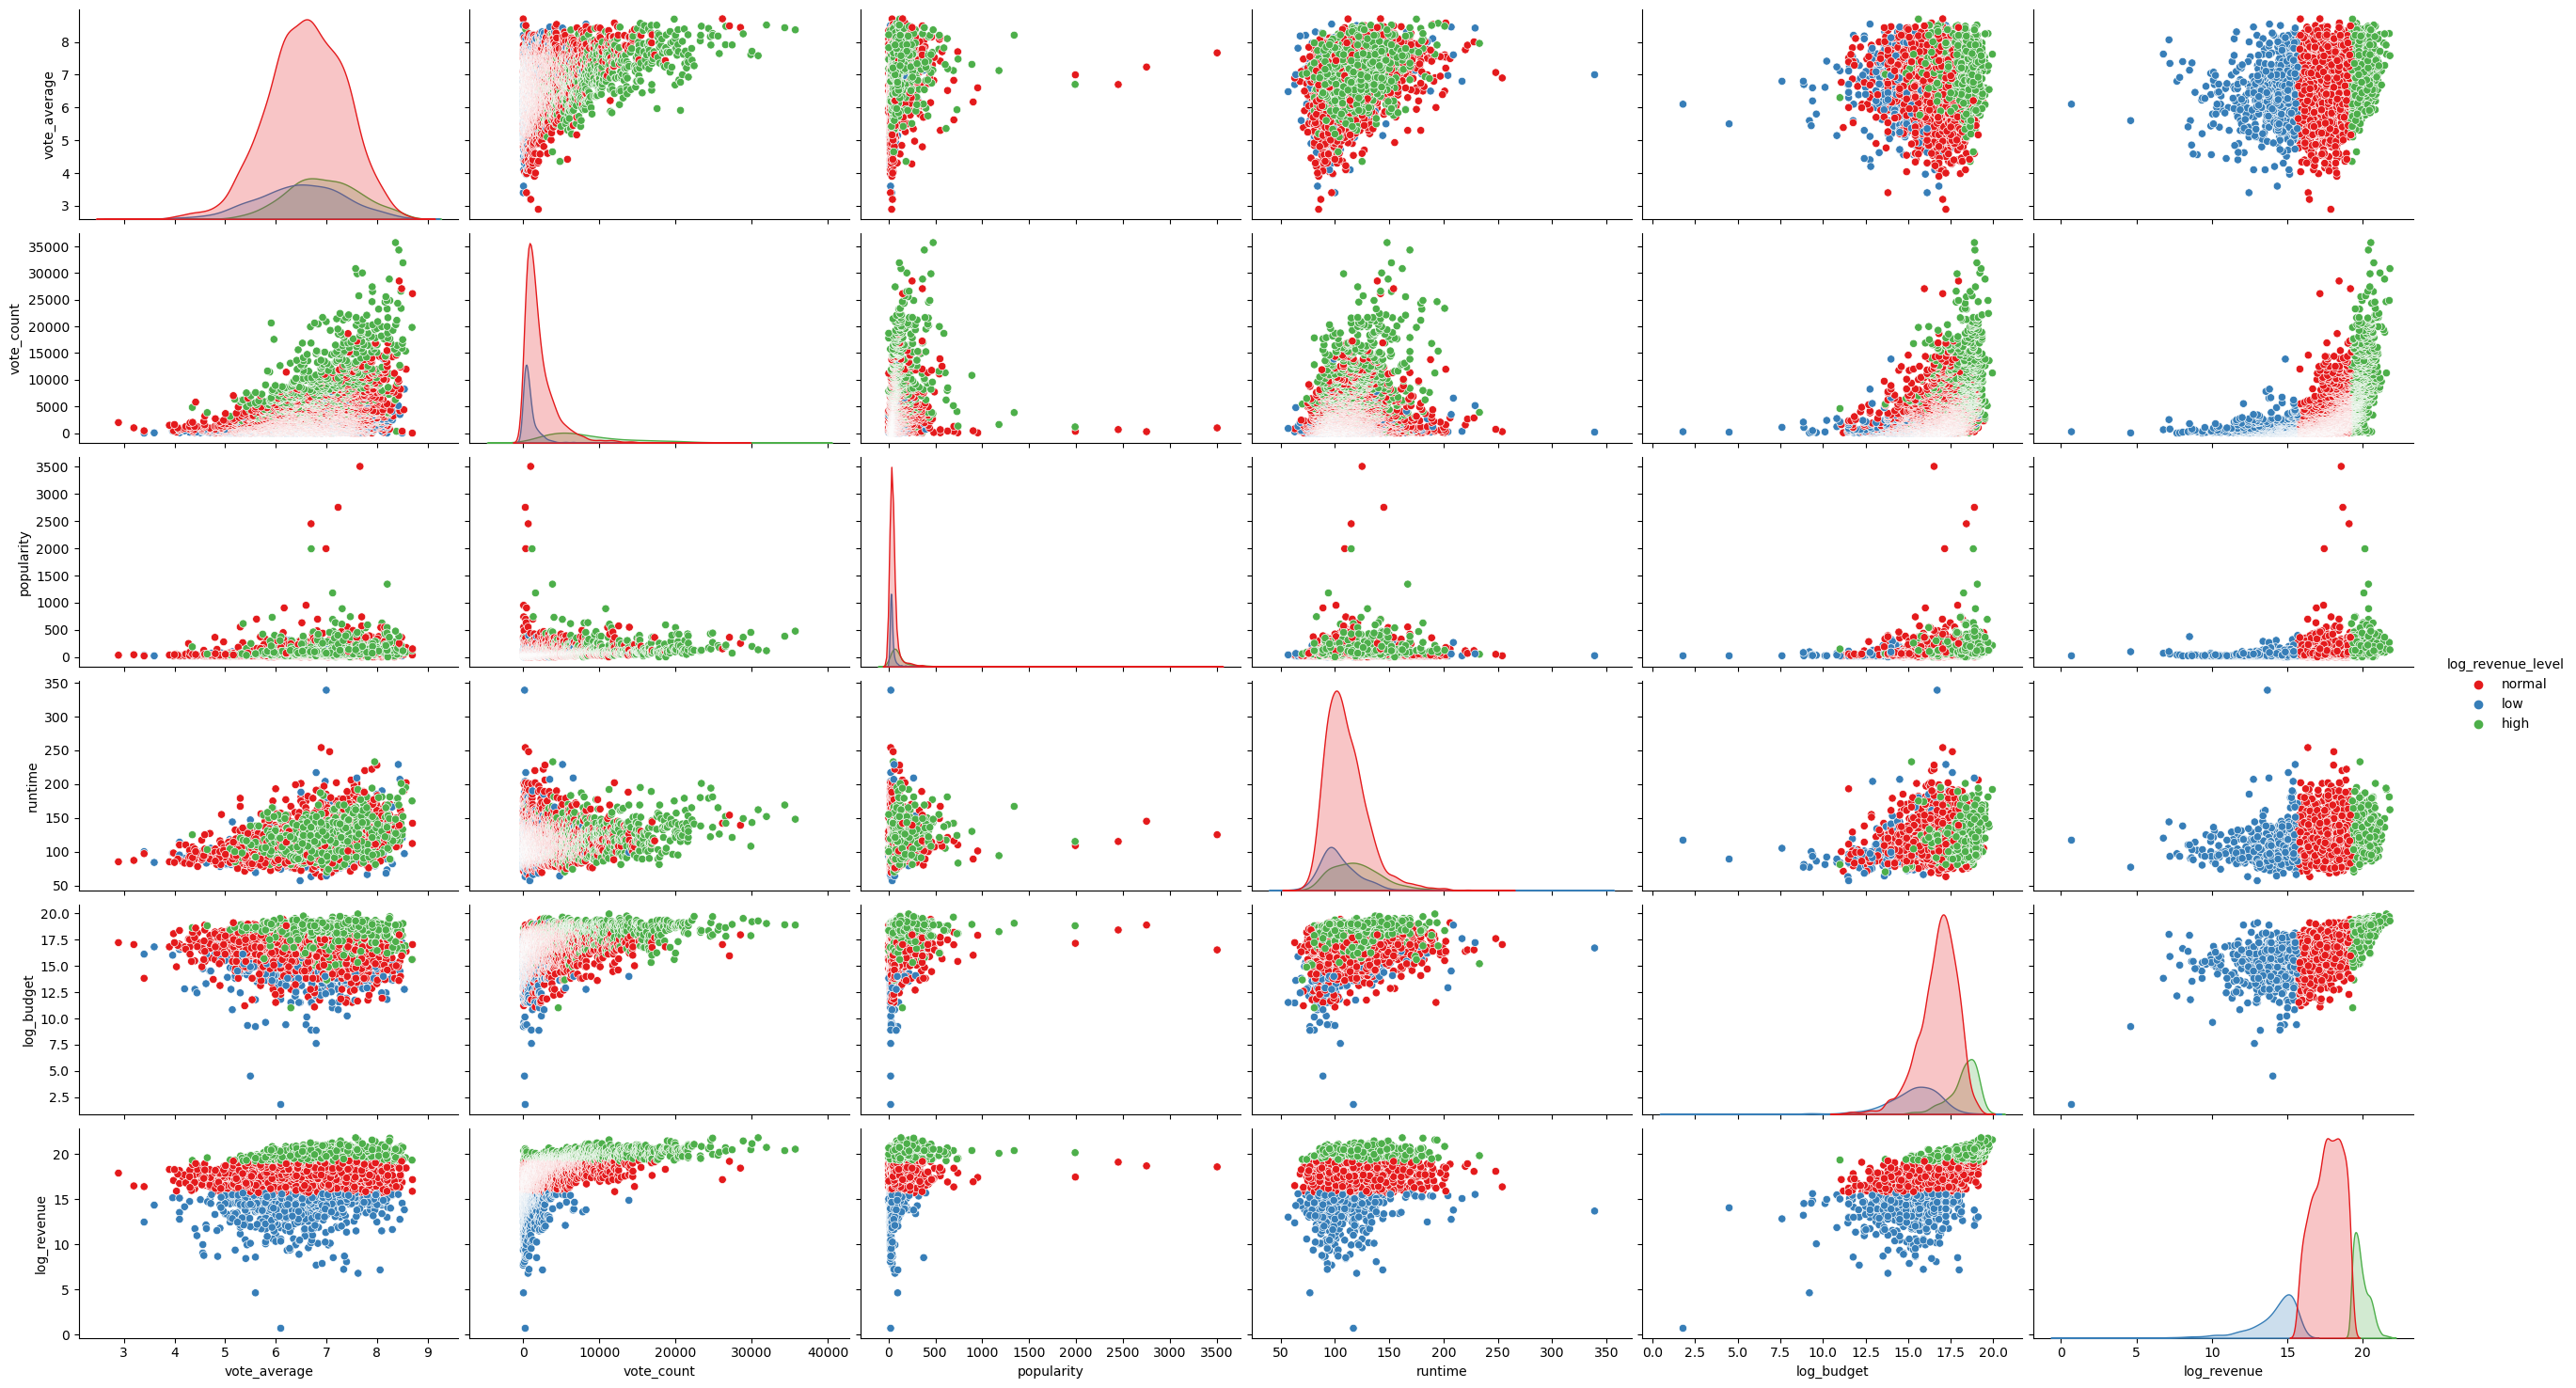

In [35]:
# vẽ biểu đồ pair plot
sns.pairplot(df[['vote_average', 'vote_count', 'popularity', 'runtime', 'log_budget', 'log_revenue', 'log_revenue_level']], hue='log_revenue_level',
             palette='Set1', height=2.5, aspect=1.75)

In [ ]:
df.drop(columns=['revenue', 'budget', 'log_revenue_level'], axis=1, inplace=True)

In [ ]:
df

In [ ]:
# df.to_csv('./Data/training_data.csv')

## **4. Tạo một baseline model**

Sử dụng Linear regression để tạo một mô hình dự đoán đơn giản

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mean Squared Error: 2.302574807539279


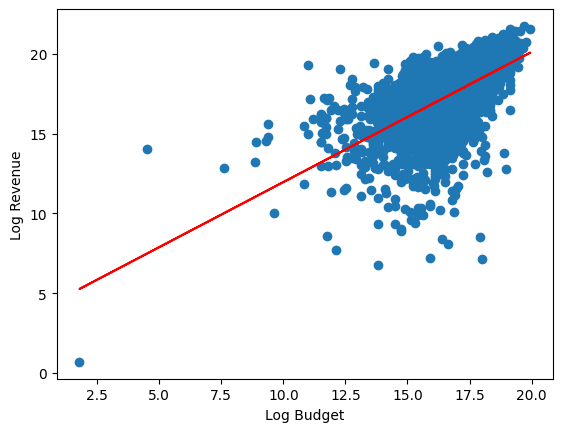

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_csv("training_data.csv")

X_train, X_test, y_train, y_test = train_test_split(data[['log_budget']], data['log_revenue'], test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


plt.scatter(X_train, y_train)
plt.plot(X_train, model.predict(X_train.values.reshape(-1, 1)), color='red')
plt.xlabel('Log Budget')
plt.ylabel('Log Revenue')
plt.show()

## **5. Xây dựng mô hình dự đoán**
### 1.Trong phần này, chúng tôi sử dụng SVR (Support Vector Regression) để đưa ra dự đoán.

In [37]:
data = pd.read_csv('./Data/training_data.csv')

In [ ]:
data.columns

Index(['Unnamed: 0', 'popularity', 'runtime', 'vote_average', 'vote_count',
       'has_homepage', 'Overview Normalization', 'Title Normalization',
       'Tagline Normalization', 'Number day released', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'origin_country_encoded', 'original_language_encoded', 'log_budget',
       'log_revenue'],
      dtype='object')

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = data['log_revenue']
X = data.drop(columns=['log_revenue', 'Unnamed: 0'], axis=1) # using all features to predict revenue

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
model.fit(X_train, y_train)

# Dự đoán doanh thu cho tập kiểm tra
predictions = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')


MSE: 2.434789781440275


In [ ]:
#Tối ưu siêu tham số dùng Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

parameters = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000], 'epsilon': [0.2, 0.25, 0.3]}

svr = SVR()

grid_search = GridSearchCV(svr, parameters, cv=3, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

cv_results = grid_search.cv_results_

for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f'Mean CV score: {mean_score}, Parameters: {params}')

print(f'Best parameters: {grid_search.best_params_}')

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 2/3] END ..C=0.1, epsilon=0.25, kernel=rbf;, score=-2.287 total time=   1.6s
[CV 1/3] END ...C=0.1, epsilon=0.2, kernel=rbf;, score=-2.177 total time=   1.8s
[CV 3/3] END ...C=0.1, epsilon=0.2, kernel=rbf;, score=-2.264 total time=   1.7s
[CV 3/3] END ..C=0.1, epsilon=0.25, kernel=rbf;, score=-2.264 total time=   1.7s
[CV 2/3] END ...C=0.1, epsilon=0.3, kernel=rbf;, score=-2.283 total time=   1.7s
[CV 2/3] END ...C=0.1, epsilon=0.2, kernel=rbf;, score=-2.285 total time=   2.0s
[CV 1/3] END ...C=0.1, epsilon=0.3, kernel=rbf;, score=-2.166 total time=   1.9s
[CV 3/3] END .....C=1, epsilon=0.2, kernel=rbf;, score=-2.151 total time=   1.9s
[CV 1/3] END ..C=0.1, epsilon=0.25, kernel=rbf;, score=-2.171 total time=   2.1s
[CV 1/3] END .....C=1, epsilon=0.2, kernel=rbf;, score=-2.041 total time=   2.3s
[CV 3/3] END ...C=0.1, epsilon=0.3, kernel=rbf;, score=-2.269 total time=   1.8s
[CV 2/3] END .....C=1, epsilon=0.2, kernel=rbf;,

In [ ]:
# Tối ưu siêu tham số dùng Random Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform

# Xác định phân phối của các tham số mà bạn muốn tìm kiếm
parameters = {'kernel': ['rbf', 'poly'], 'C': uniform(loc=5, scale=150), 'epsilon': uniform(loc=0, scale=1)}

svr = SVR()

random_search = RandomizedSearchCV(svr, parameters, cv=5, scoring='neg_mean_squared_error', n_iter=10, random_state=42, verbose=3, n_jobs=-1)

random_search.fit(X_train, y_train)

print(f'Best parameters: {random_search.best_params_}')

best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END C=61.18101782710438, epsilon=0.9507143064099162, kernel=rbf;, score=-2.176 total time=   1.0s
[CV 5/5] END C=61.18101782710438, epsilon=0.9507143064099162, kernel=rbf;, score=-1.801 total time=   1.1s
[CV 1/5] END C=61.18101782710438, epsilon=0.9507143064099162, kernel=rbf;, score=-2.041 total time=   1.1s
[CV 3/5] END C=61.18101782710438, epsilon=0.9507143064099162, kernel=rbf;, score=-1.997 total time=   1.2s
[CV 2/5] END C=61.18101782710438, epsilon=0.9507143064099162, kernel=rbf;, score=-1.994 total time=   1.7s
[CV 1/5] END C=55.05629167085328, epsilon=0.14286681792194078, kernel=rbf;, score=-2.091 total time=   2.8s
[CV 2/5] END C=55.05629167085328, epsilon=0.14286681792194078, kernel=rbf;, score=-2.015 total time=   3.3s
[CV 3/5] END C=55.05629167085328, epsilon=0.14286681792194078, kernel=rbf;, score=-2.010 total time=   2.0s
[CV 4/5] END C=55.05629167085328, epsilon=0.14286681792194078, kernel=rbf;, scor

In [ ]:
# Tối ưu siêu tham số dùng Bayesian optimization
# !pip install scikit-optimize
from sklearn import metrics
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

opt = BayesSearchCV(
    SVR(),
    {
        'kernel': Categorical(['rbf', 'poly']),
        'C': Real(1e-1, 1e+2, prior = 'log-uniform'),
        'epsilon': Real(1e-1, 1e+1, prior = 'log-uniform')
    },
    n_iter = 32,
    random_state = 0,
    verbose = 1
)

_ = opt.fit(X_train, y_train.ravel())

y_train_pred = opt.predict(X_train)
y_test_pred = opt.predict(X_test)

print(f'Train MSE: {metrics.mean_squared_error(y_train, y_train_pred)}')
print(f'Test MSE: {metrics.mean_squared_error(y_test, y_test_pred)}')

opt.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

OrderedDict([('C', 100.0), ('epsilon', 0.9481951230369121), ('kernel', 'rbf')])

### 2, Ensemble method: Random forest 
- Sử dụng random forest bởi vì độ tương quan giữa các feature với nhau khá thấp

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X = data.drop(columns=['log_revenue', 'Unnamed: 0'])
y = data['log_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

regressor = RandomForestRegressor(n_estimators= 10, random_state=0)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')


MSE: 1.4792352647706066


In [42]:
print(regressor.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Tuning Hyparameter Random forest sử dụng Random Search

In [44]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(f'Best parameters: {rf_random.best_params_}')

best_model = rf_random.best_estimator_
predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

## **6. Sử dụng PCA để giảm chiều dữ liệu**
Trong phần này chúng tôi sử dụng PCA (Principal Components Analysis) để giảm chiều dữ liệu, đưa bộ dữ liệu huấn luyện từ 32 chiều còn 5 chiều.

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

data = pd.read_csv('training_data.csv')

# Chuẩn bị dữ liệu
X = data.drop(columns=['log_revenue', 'Unnamed: 0'], axis=1)
y = data['log_revenue']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tạo một pipeline với PCA và SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

# Tạo một lưới các tham số để kiểm tra với GridSearch
param_grid = {
    'pca__n_components': range(5, X.shape[1]+1),  # Kiểm tra từ 1 đến số lượng cột của X
    'svr__C': [1, 10, 100],  # Thêm các giá trị khác nếu muốn
    'svr__epsilon': [0.1, 0.2, 0.3],  # Thêm các giá trị khác nếu muốn
    'svr__kernel': ['rbf', 'poly']  # Thêm các kernel bạn muốn thử
}

# Thực hiện GridSearch
grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=3)
grid.fit(X_train, y_train)

# In ra số lượng thành phần chính tốt nhất và các tham số tốt nhất của SVR
print("Số lượng thành phần chính tốt nhất: ", grid.best_params_['pca__n_components'])
print("Tham số tốt nhất của SVR: C=", grid.best_params_['svr__C'], ", epsilon=", grid.best_params_['svr__epsilon'], ", kernel=", grid.best_params_['svr__kernel'])

# Huấn luyện lại mô hình với tham số tốt nhất
best_pca_n_components = grid.best_params_['pca__n_components']
best_svr_C = grid.best_params_['svr__C']
best_svr_epsilon = grid.best_params_['svr__epsilon']
best_svr_kernel = grid.best_params_['svr__kernel']

pipeline_best = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_pca_n_components)),
    ('svr', SVR(C=best_svr_C, epsilon=best_svr_epsilon, kernel=best_svr_kernel))
])

pipeline_best.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = pipeline_best.predict(X_test)

# Tính MSE
mse = mean_squared_error(y_test, y_pred)

# In ra MSE
print("MSE: ", mse)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV 3/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.1, svr__kernel=poly;, score=0.224 total time=   1.4s
[CV 3/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.1, svr__kernel=rbf;, score=0.365 total time=   1.4s
[CV 2/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.1, svr__kernel=poly;, score=0.226 total time=   1.7s
[CV 2/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.2, svr__kernel=rbf;, score=0.373 total time=   1.8s
[CV 2/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.2, svr__kernel=poly;, score=0.237 total time=   1.8s
[CV 1/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.2, svr__kernel=poly;, score=0.070 total time=   1.8s
[CV 1/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.2, svr__kernel=rbf;, score=0.380 total time=   1.9s
[CV 1/3] END pca__n_components=5, svr__C=1, svr__epsilon=0.1, svr__kernel=poly;, score=-0.065 total time=   1.9s
[CV 2/3] END pca__n_components=5, svr__C=1

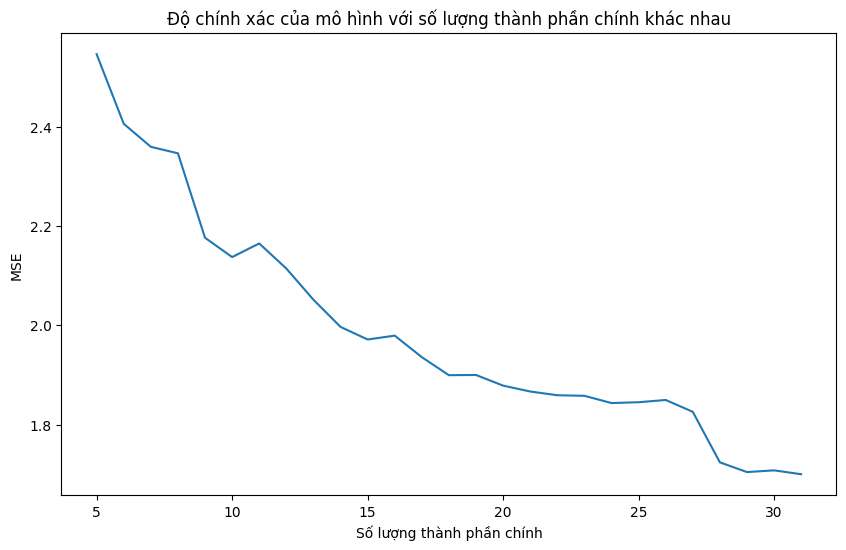

In [ ]:
import matplotlib.pyplot as plt

# Tạo một danh sách để lưu trữ MSE tương ứng với từng giá trị của n_components
mse_list = []

# Thử nghiệm với từng giá trị của n_components
for n in range(5, X.shape[1] + 1):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('svr', SVR(C=best_svr_C, epsilon=best_svr_epsilon, kernel=best_svr_kernel))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range(5, X.shape[1] + 1), mse_list)
plt.title('Độ chính xác của mô hình với số lượng thành phần chính khác nhau')
plt.xlabel('Số lượng thành phần chính')
plt.ylabel('MSE')
plt.grid(False)
plt.show()
